In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from scipy import stats
warnings.filterwarnings(action='ignore')
%matplotlib inline
%pylab
%config InlineBackend.figure_format = 'retina'

temporada = 2017

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


#### Pasos para el cálculo del "Wins Produced"

Para el cálculo de esta medida de valoración de los jugadores, vamos a partir de dos csv, uno con datos a nivel de encuentro, y otro con datos a nivel de jugador. Ambos contienen la información del boxscore de cada encuentro, pero a distintos niveles de agrupación.

Con este primer csv obtendremos la influencia de cada métrica del boxscore sobre el resultado del partido (W/L) a través de un modelo de regresión.

Posteriormente, utilizaremos esa influencia que hemos obtenido, para calcular la medida de valoración "Wins Produced" a nivel de jugador en cada encuentro. Para este cálculo utilizaremos el segundo csv, que contiene los datos a nivel de jugador.

Una vez obtenido el "Wins Produced", lo utilizaremos para generar dos nuevas variables que incluiremos en nuestro modelo de predicción del resultado de los partidos.

Una de ellas, será una variable de calidad de los jugadores que participan en el encuentro, basada en una media de esta variable en lo que va de temporada para dichos jugadores.

La otra variable será una dummy que indica si el jugador que más aporta al equipo participa en el encuentro o no.

### Creamos el modelo para el cálculo del Wins Produced

In [15]:
# Importamos los datos con información de los partidos desde la visión de local

partidos = pd.read_csv('input.csv')
partidos = partidos.drop_duplicates()
partidos = partidos.dropna()

# Modificamos el formato de algunas variables 

partidos = partidos.drop(columns=['Date'])
partidos['Date']=partidos['ID Partido'].str.extract(pat='(2\w{7})')

partidos['Year'] = partidos['Year'].astype(int)
partidos['Season'] = partidos['Season'].astype(int)
partidos['Points'] = partidos['Points'].astype(int)
partidos['Opponent_Points'] = partidos['Opponent_Points'].astype(int)
partidos['Result_local'] = np.where(partidos['Points'] > partidos['Opponent_Points'], 'W', 'L')
partidos['Result_visitor'] = np.where(partidos['Points'] < partidos['Opponent_Points'], 'W', 'L')


# Seleccionamos las temporadas a incluir en nuestro modelo

temporada = 2017

partidos = partidos.loc[partidos['Season'] > temporada]


#### Creamos el DF para la regresión a nivel de equipo ####

# Dividimos el DF en dos para tenerlo a nivel de equipo, es decir, una fila con el dato del local y otra con el visitante

partidos_visitor = partidos.loc[:, ['Date', 'Year', 'Season', 'ID Partido', 'local_team', 'visitor_team', 'Opponent_Points', 
           'Result_visitor', 'visitor_fg', 'visitor_fga', 'visitor_fg_pct', 'visitor_fg3', 'visitor_fg3a','visitor_fg3_pct',
           'visitor_ft', 'visitor_fta', 'visitor_ft_pct', 'visitor_orb', 'visitor_drb', 'visitor_ast', 'visitor_stl', 
           'visitor_blk', 'visitor_tov', 'visitor_pf', 'visitor_pts', 'visitor_Conf_position', 'visitor_Win', 'visitor_Lose', 
           'visitor_Percentagewl', 'visitor_Dif_leader', 'visitor_Home_win', 'visitor_Home_lose', 'visitor_Away_win', 
           'visitor_Away_lose', 'visitor_Div_win', 'visitor_Div_lose', 'visitor_Cnf_win', 'visitor_Cnf_lose', 'visitor_Icf_win',
           'visitor_Icf_lose', 'local_ft', 'Sueldo visitante', 'Visitor_Division', 'Visitor_Conferencia', 'visitor_trb',
           'VISITANTE_Ultimos10Victorias', 'VISITANTE_Ultimos10Derrotas', 'VISITANTE_Racha', 'VISITOR_AWS_MEDIO_AGRUPADO']]


# Eliminamos los datos del visitante para el DF del local

partidos = partidos.drop(columns=['Opponent_Points', 'Result_visitor', 'Result','visitor_fg', 'visitor_fga', 'visitor_fg_pct',
           'visitor_fg3', 'visitor_fg3a','visitor_fg3_pct', 'visitor_fta', 'visitor_ft_pct', 'visitor_orb', 'visitor_drb', 
           'visitor_ast', 'visitor_stl', 'visitor_blk', 'visitor_tov', 'visitor_pf', 'visitor_pts', 'visitor_Conf_position',
           'visitor_Win', 'visitor_Lose', 'visitor_trb', 'visitor_Percentagewl', 'visitor_Dif_leader', 'visitor_Home_win',
           'visitor_Home_lose', 'visitor_Away_win','visitor_Away_lose', 'visitor_Div_win', 'visitor_Div_lose','visitor_Cnf_win',
           'visitor_Cnf_lose', 'visitor_Icf_win', 'visitor_Icf_lose', 'Sueldo visitante', 'Visitor_Division',
           'Visitor_Conferencia', 'VISITANTE_Ultimos10Victorias', 'VISITANTE_Ultimos10Derrotas', 'VISITANTE_Racha',
            'VISITOR_AWS_MEDIO_AGRUPADO'])


# Unificamos los nombres de las variables en ambos DF

partidos = partidos.rename(columns=lambda x: x.replace('local_', ''))
partidos = partidos.rename(columns=lambda x: x.replace('LOCAL_', ''))
partidos = partidos.rename(columns=lambda x: x.replace('Local_', ''))

partidos.rename(columns={'Result_local': 'Result', 'team': 'team_PoV', 'visitor_team': 'Opponent_team', 
                         'visitor_ft': 'FTM_opp', 'Sueldo local': 'Sueldo'}, inplace=True)

partidos_visitor = partidos_visitor.rename(columns=lambda x: x.replace('visitor_', ''))
partidos_visitor = partidos_visitor.rename(columns=lambda x: x.replace('VISITANTE_', ''))
partidos_visitor = partidos_visitor.rename(columns=lambda x: x.replace('Visitor_', ''))
partidos_visitor = partidos_visitor.rename(columns=lambda x: x.replace('VISITOR_', ''))

partidos_visitor.rename(columns={'Result_visitor': 'Result', 'team': 'team_PoV', 'local_team': 'Opponent_team', 
                                 'Opponent_Points': 'Points', 'local_ft': 'FTM_opp', 'Sueldo visitante':'Sueldo'}, inplace=True)


# Unimos ambos DF verticamente 

partidos_union = pd.concat([partidos, partidos_visitor])


# Creamos las variables necesarias para el cálculo

partidos_union['2FGM'] = partidos_union['fg'] - partidos_union['fg3']
partidos_union['FGMS'] = partidos_union['fga'] - partidos_union['fg']
partidos_union['FTMS'] = partidos_union['fta'] - partidos_union['ft']

partidos_union.rename(columns={'fg3': '3FGM', 'ft': 'FTM', 'orb': 'REBO', 'drb': 'REBD', 'tov': 'TO', 'stl': 'STL', 
                                 'blk': 'BLK'}, inplace=True)


# Generamos la variable dummy Win que tomará valor 1 si el equipo ganó el encuentro

partidos_union['Win'] = np.where(partidos_union['Result'] == 'W', 1, 0)


# Creamos un DF con las variables del modelo

partidos_union_reg = partidos_union.loc[:, ['3FGM', '2FGM', 'FTM', 'FGMS', 'FTMS', 'REBO', 'REBD', 'TO', 'STL', 
                                            'FTM_opp', 'BLK', 'Win']]

print(partidos_union_reg.head(5))


#### Generamos el modelo de regresión ####

# Creamos las variables X e Y del modelo

x = partidos_union_reg.loc[:, ['3FGM', '2FGM', 'FTM', 'FGMS', 'FTMS', 'REBO', 'REBD', 'TO', 'STL', 
                                            'FTM_opp', 'BLK']]

y = partidos_union_reg.loc[:, ['Win']]


from statsmodels.api import OLS

model = OLS(y,x).fit()

print('\n',model.summary())

var = pd.DataFrame(dict(zip(x.columns,model.params)),index=[0]).T

      3FGM  2FGM  FTM  FGMS  FTMS  REBO  REBD  TO  STL  FTM_opp  BLK  Win
2627     6    11   10    27     3     5    19   8    4        5    1    0
2629     8    14    2    29     3     7    13   5    8        6    5    0
2630     9    15    2    24     2     7    17  11    6        8    1    1
2631     8    14    4    27     3     7    17  11    6        4    6    1
2632     7    23    7    21     3     3    16   4    7        7    3    0

                             OLS Regression Results                            
Dep. Variable:                    Win   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     963.6
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        19:02:27   Log-Likelihood:                -4400.7
No. Observations:                7136   AIC:                             8823.
D

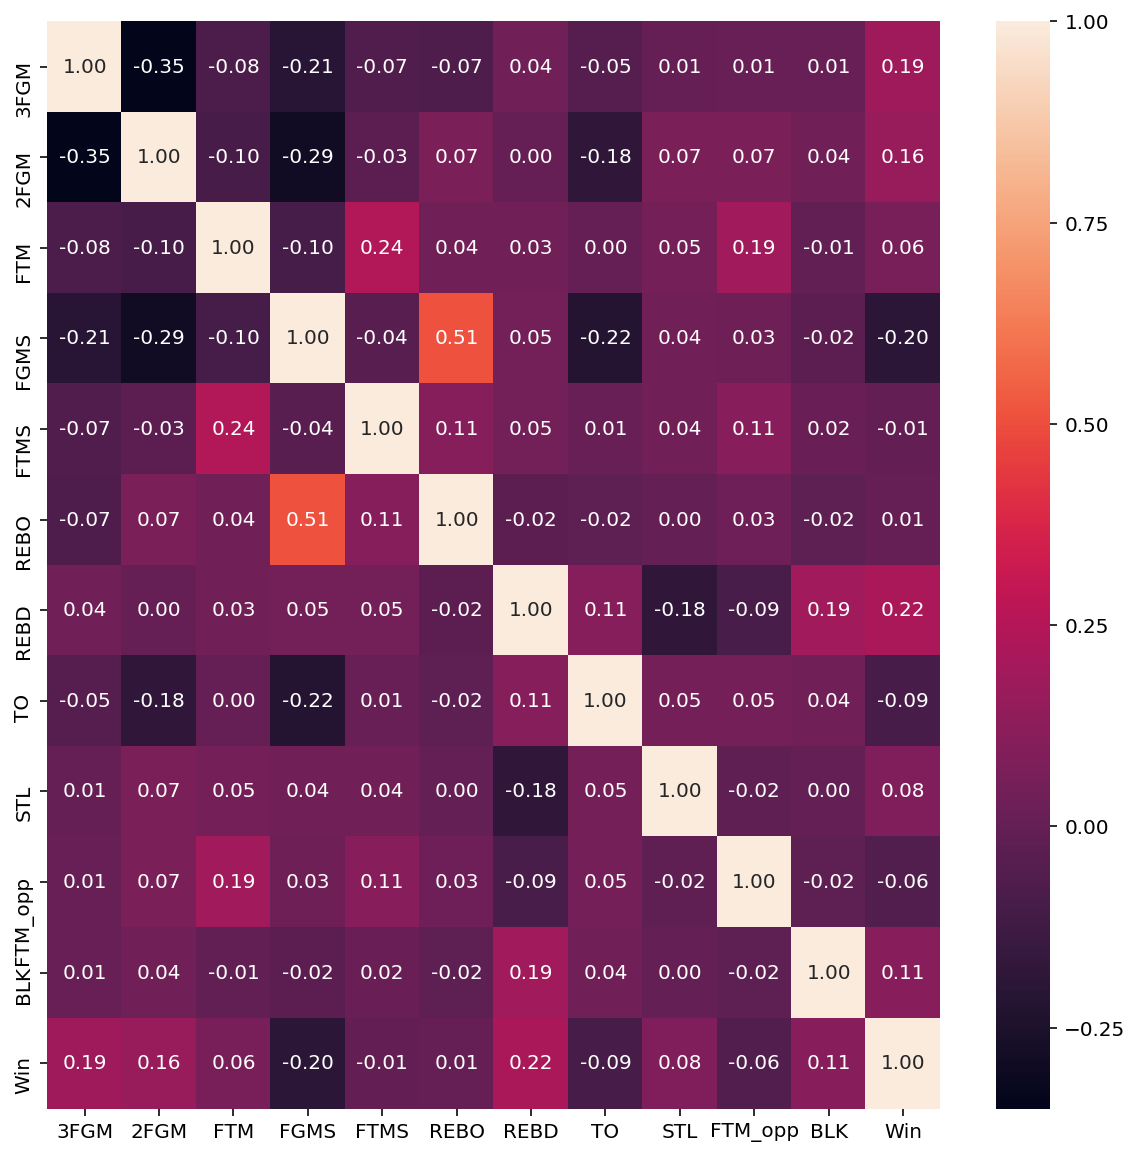

In [16]:
plt.figure(figsize=(10,10))
sns.heatmap(partidos_union_reg.corr(), annot=True, fmt='.2f')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025D2CBC4358>,
      dtype=object)

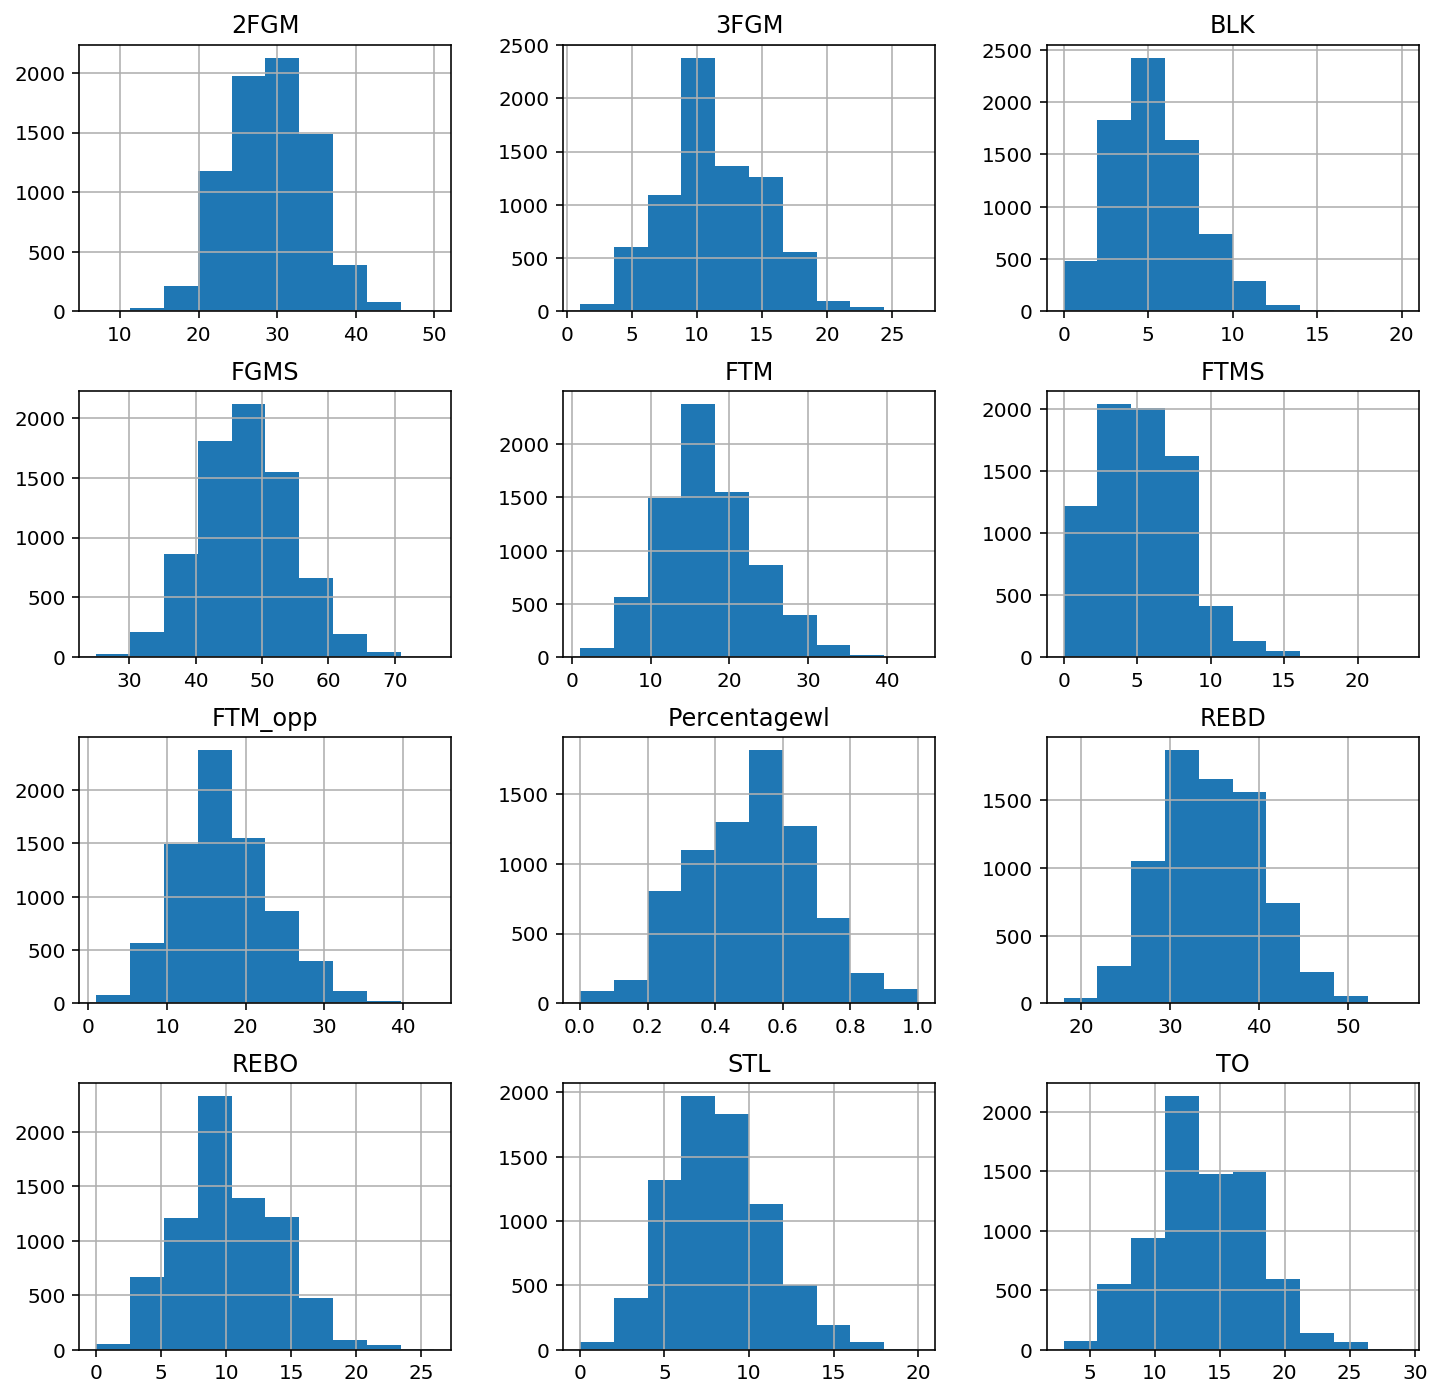

In [37]:
partidos_union_reg.hist(figsize = (12, 12))

### Calculamos el Wins Produced con las ponderaciones obtenidas con el modelo de regresión

### Calculamos el WP a nivel de jugador en cada encuentro

In [19]:
# Importamos el csv con la información de los partidos a nivel de jugador

jugadores = pd.read_csv('Stats_jugadores_27_04_20.csv')
jugadores = jugadores.dropna()

# Modificamos el formato de algunas variables

jugadores['Year'] = jugadores['Year'].astype(int)
jugadores['Season'] = jugadores['Season'].astype(int)

jugadores['Team Points'] = jugadores['Team Points'].astype(int)
jugadores['Opponent Points'] = jugadores['Opponent Points'].astype(int)
jugadores['Result'] = np.where(jugadores['Team Points'] > jugadores['Opponent Points'], 'W', 'L')

jugadores = jugadores.drop(columns=['Date'])
jugadores['Date']=jugadores['ID Partido'].str.extract(pat='(2\w{7})')


# Seleccionamos las temporadas a incluir en nuestro modelo

jugadores_WP = jugadores.loc[jugadores['Season'] > temporada]


# Creamos las variables necesarias para el cálculo

jugadores_WP['2FGM'] = jugadores_WP['Tiros anotados'] - jugadores_WP['Tiros de tres anotados']
jugadores_WP['FGMS'] = jugadores_WP['Tiros intentados'] - jugadores_WP['Tiros anotados']
jugadores_WP['FTMS'] = jugadores_WP['Tiros libres intentados'] - jugadores_WP['Tiros libres anotados']


# Renombramos las variables que vamos a usar para nuestro calculo del AWS

jugadores_WP.rename(columns={'Tiros de tres anotados': '3FGM', 'Tiros libres anotados': 'FTM', 'Rebotes ofensivos': 'REBO',
                                 'Rebotes defensivo': 'REBD', 'Robos': 'STL', 'Tapones': 'BLK', 'Perdidas': 'TO'}, inplace=True)


# Generamos la variable de faltas del total del equipo para obtener el porcentaje de faltas de cada jugador sobre ese total

jugadores_WP_Faltas = jugadores_WP.groupby(['ID Partido', 'Team'], as_index=False).agg({'Faltas':'sum'})

jugadores_WP_df_jugador = pd.merge(jugadores_WP, jugadores_WP_Faltas, how='left', on=['ID Partido', 'Team'])

jugadores_WP_df_jugador.rename(columns={'Faltas_x': 'Faltas jugador', 'Faltas_y': 'Faltas equipo'}, inplace=True)

jugadores_WP_df_jugador['Pct faltas jugador'] = jugadores_WP_df_jugador['Faltas jugador'] / jugadores_WP_df_jugador['Faltas equipo']


# Generamos la variable FTMopp con los tiros libres realizados del total del equipo oponente

jugadores_WP_df_FTMopp = jugadores_WP_df_jugador.groupby(['ID Partido', 'Local'], as_index=False).agg({'FTM':'sum'})

jugadores_WP_df_FTMopp['Local'] = np.where(jugadores_WP_df_FTMopp['Local'] == True, 'False', 'True')

jugadores_WP_df_FTMopp.rename(columns={'FTM': 'FTM_opp_team'}, inplace=True)

jugadores_WP_df_jugador['Local'] = jugadores_WP_df_jugador['Local'].astype(str)

jugadores_WP_df_jugador = pd.merge(jugadores_WP_df_jugador, jugadores_WP_df_FTMopp, how='left', on=['ID Partido', 'Local'])


# Obtenemos el DF final para el cálculo del WP

jugadores_WP_df_jugador['FTM_opp'] = jugadores_WP_df_jugador['Pct faltas jugador'] * jugadores_WP_df_jugador['FTM_opp_team']

jugadores_WP_df_jugador

,Team,Season,Year,ID Partido,Local,Opponent,Team Points,Opponent Points,Result,Name,...,Box plus minus,Usage percentage,Date,2FGM,FGMS,FTMS,Faltas equipo,Pct faltas jugador,FTM_opp_team,FTM_opp
0,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Simmons,Ben",...,4.8,20.6,20171018,7.0,7.0,2.0,28.0,0.107143,30.0,3.214286
1,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Redick,J.J.",...,-1.7,15.0,20171018,0.0,6.0,0.0,28.0,0.142857,30.0,4.285714
2,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Covington,Robert",...,13.7,30.3,20171018,2.0,6.0,0.0,28.0,0.142857,30.0,4.285714
3,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Bayless,Jerryd",...,0.5,17.5,20171018,2.0,5.0,0.0,28.0,0.142857,30.0,4.285714
4,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Embiid,Joel",...,-1.2,31.2,20171018,7.0,8.0,0.0,28.0,0.071429,30.0,2.142857
5,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Šarić,Dario",...,-6.9,9.7,20171018,1.0,4.0,0.0,28.0,0.107143,30.0,3.214286
6,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Luwawu-Cabarrot,Timothé",...,-1.1,13.3,20171018,1.0,4.0,0.0,28.0,0.071429,30.0,2.142857
7,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Fultz,Markelle",...,-3.4,26.9,20171018,5.0,4.0,2.0,28.0,0.000000,30.0,0.000000
8,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Johnson,Amir",...,-17.6,23.8,20171018,2.0,5.0,1.0,28.0,0.214286,30.0,6.428571
9,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"McConnell,T.J.",...,-2.2,5.4,20171018,1.0,1.0,0.0,28.0,0.000000,30.0,0.000000


### Calculamos el Wins Produced a nivel de jugador en cada partido

In [20]:
# Calculamos el Wins Produced

jugadores_WP_df_jugador['WP'] = var[0]['3FGM'] * jugadores_WP_df_jugador['3FGM'] + var[0]['2FGM'] * jugadores_WP_df_jugador['2FGM'] + \
                    + var[0]['FTM'] * jugadores_WP_df_jugador['FTM'] + var[0]['FGMS'] * jugadores_WP_df_jugador['FGMS'] + \
                    + var[0]['FTMS'] * jugadores_WP_df_jugador['FTMS'] + var[0]['REBO'] * jugadores_WP_df_jugador['REBO'] + \
                    + var[0]['REBD'] * jugadores_WP_df_jugador['REBD'] + var[0]['TO'] * jugadores_WP_df_jugador['TO'] + \
                    + var[0]['STL'] * jugadores_WP_df_jugador['STL'] + var[0]['FTM_opp'] * jugadores_WP_df_jugador['FTM_opp'] + \
                    + var[0]['BLK'] * jugadores_WP_df_jugador['BLK']

jugadores_WP_df_jugador

,Team,Season,Year,ID Partido,Local,Opponent,Team Points,Opponent Points,Result,Name,...,Usage percentage,Date,2FGM,FGMS,FTMS,Faltas equipo,Pct faltas jugador,FTM_opp_team,FTM_opp,WP
0,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Simmons,Ben",...,20.6,20171018,7.0,7.0,2.0,28.0,0.107143,30.0,3.214286,0.302562
1,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Redick,J.J.",...,15.0,20171018,0.0,6.0,0.0,28.0,0.142857,30.0,4.285714,-0.008159
2,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Covington,Robert",...,30.3,20171018,2.0,6.0,0.0,28.0,0.142857,30.0,4.285714,0.275650
3,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Bayless,Jerryd",...,17.5,20171018,2.0,5.0,0.0,28.0,0.142857,30.0,4.285714,0.052837
4,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Embiid,Joel",...,31.2,20171018,7.0,8.0,0.0,28.0,0.071429,30.0,2.142857,0.267625
5,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Šarić,Dario",...,9.7,20171018,1.0,4.0,0.0,28.0,0.107143,30.0,3.214286,0.013481
6,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Luwawu-Cabarrot,Timothé",...,13.3,20171018,1.0,4.0,0.0,28.0,0.071429,30.0,2.142857,0.025811
7,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Fultz,Markelle",...,26.9,20171018,5.0,4.0,2.0,28.0,0.000000,30.0,0.000000,-0.003934
8,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"Johnson,Amir",...,23.8,20171018,2.0,5.0,1.0,28.0,0.214286,30.0,6.428571,-0.005907
9,Philadelphia 76ers,2018,2017,/boxscores/201710180WAS.html,False,Washington Wizards,115,120,L,"McConnell,T.J.",...,5.4,20171018,1.0,1.0,0.0,28.0,0.000000,30.0,0.000000,-0.012645


### Obtenemos jugador con mayor Wins Produced del equipo en cada temporada

In [21]:
# Obtenemos el WP por jugador para la temporada

jugadores_WP_MEAN = jugadores_WP_df_jugador.groupby(['Team','Name', 'Season'], as_index=False)['WP'].agg({'WP_MEAN':'mean'})


# Obtenemos la estrella del equipo. Es decir, aquel jugador que tiene mayor WP medio en cada equipo

WP_Star = jugadores_WP_MEAN.groupby(['Team', 'Season'])['WP_MEAN'].transform(max) == jugadores_WP_MEAN['WP_MEAN']

print('Dataframe de jugador estrella de cada equipo por temporada: ')
jugadores_WP_MEAN[WP_Star]

Dataframe de jugador estrella de cada equipo por temporada: 


,Team,Name,Season,WP_MEAN
16,Atlanta Hawks,"Collins,John",2019,0.259570
17,Atlanta Hawks,"Collins,John",2020,0.335331
20,Atlanta Hawks,"Dedmon,Dewayne",2018,0.239036
81,Boston Celtics,"Horford,Al",2018,0.210532
82,Boston Celtics,"Horford,Al",2019,0.206782
86,Boston Celtics,"Kanter,Enes",2020,0.234188
120,Brooklyn Nets,"Allen,Jarrett",2018,0.169954
134,Brooklyn Nets,"Davis,Ed",2019,0.273836
149,Brooklyn Nets,"Jordan,DeAndre",2020,0.333292
198,Charlotte Hornets,"Howard,Dwight",2018,0.343700


In [58]:
jugadores_WP_df_jugador.to_csv('jugadores_WP_df_jugador.csv', index = False)